# 01 - Data Exploration and Setup

Goals:
1. Download ChestX-ray14 from Kaggle
2. Explore dataset structure
3. Analyze label distribution and co-occurrence
4. Create patient-level train/validation/calibration/test splits
5. Save splits for reproducibility

In [1]:
# Imports and setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter

PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data" / "chestxray14"
DATA_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")

Project root: /Users/ADRIAN/Dev/College/Research Project
Data directory: /Users/ADRIAN/Dev/College/Research Project/data/chestxray14


In [2]:
# Download dataset from Kaggle

import kagglehub

# This will download to kagglehub's cache directory
# First time will take a while (~45GB)
print("Downloading ChestX-ray14 from Kaggle...")
print("(This may take 30-60 minutes on first run)")

kaggle_path = kagglehub.dataset_download("nih-chest-xrays/data")
print(f"\nDataset downloaded to: {kaggle_path}")

(This may take 30-60 minutes on first run)


/Users/ADRIAN/Dev/College/Research Project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Dataset downloaded to: /Users/ADRIAN/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3


In [3]:
# Explore downloaded files

kaggle_path = Path(kaggle_path)

print("Contents of downloaded directory:")
for item in sorted(kaggle_path.iterdir()):
    if item.is_dir():
        n_files = len(list(item.iterdir()))
        print(f"    - {item.name}/ ({n_files} items)")
    else:
        size_mb = item.stat().st_size / (1024 ** 2)
        print(f"    - {item.name} ({size_mb:.1f} MB)")

Contents of downloaded directory:
    - ARXIV_V5_CHESTXRAY.pdf (8.5 MB)
    - BBox_List_2017.csv (0.1 MB)
    - Data_Entry_2017.csv (7.5 MB)
    - FAQ_CHESTXRAY.pdf (0.1 MB)
    - LOG_CHESTXRAY.pdf (0.0 MB)
    - README_CHESTXRAY.pdf (0.8 MB)
    - images_001/ (1 items)
    - images_002/ (1 items)
    - images_003/ (1 items)
    - images_004/ (1 items)
    - images_005/ (1 items)
    - images_006/ (1 items)
    - images_007/ (1 items)
    - images_008/ (1 items)
    - images_009/ (1 items)
    - images_010/ (1 items)
    - images_011/ (1 items)
    - images_012/ (1 items)
    - test_list.txt (0.4 MB)
    - train_val_list.txt (1.4 MB)


In [4]:
# Load metadata CSV

# Find the CSV file (might be named differently)
csv_files = list(kaggle_path.glob("*.csv"))
print("CSV files found: ", [f.name for f in csv_files])

metadata_path = None
for f in csv_files:
    if "entry" in f.name.lower() or "data" in f.name.lower():
        metadata_path = f
        break

if metadata_path is None:
    metadata_path = csv_files[0]

print(f"\nLoading metadata from: {metadata_path.name}")
df = pd.read_csv(metadata_path)

print(f"\nDataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few columns:")
df.head()

CSV files found:  ['Data_Entry_2017.csv', 'BBox_List_2017.csv']

Loading metadata from: Data_Entry_2017.csv

Dataset shape: (112120, 12)

Columns: ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']

First few columns:


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [5]:
# Understand the data structure

print("Dataset Info:")
print(f"    Total images: {len(df):,}")
print(f"    Unique patients: {df['Patient ID'].nunique():,}")
print(f"    Images per patient: {len(df) / df['Patient ID'].nunique():.1f} (avg)")

print(f"\nSample 'Finding Labels' values:")
for label in df['Finding Labels'].head(10):
    print(f"    {label}")

Dataset Info:
    Total images: 112,120
    Unique patients: 30,805
    Images per patient: 3.6 (avg)

Sample 'Finding Labels' values:
    Cardiomegaly
    Cardiomegaly|Emphysema
    Cardiomegaly|Effusion
    No Finding
    Hernia
    Hernia
    Hernia
    Hernia|Infiltration
    Hernia
    Hernia


In [6]:
# Define the 14 pathology labels

LABELS = [
    "Atelectasis",
    "Cardiomegaly",
    "Effusion",
    "Infiltration",
    "Mass",
    "Nodule",
    "Pneumonia",
    "Pneumothorax",
    "Consolidation",
    "Edema",
    "Emphysema",
    "Fibrosis",
    "Pleural_Thickening",
    "Hernia"
]

print(f"14 Pathology Labels:")
for i, label in enumerate(LABELS):
    print(f"    {i}: {label}")

14 Pathology Labels:
    0: Atelectasis
    1: Cardiomegaly
    2: Effusion
    3: Infiltration
    4: Mass
    5: Nodule
    6: Pneumonia
    7: Pneumothorax
    8: Consolidation
    9: Edema
    10: Emphysema
    11: Fibrosis
    12: Pleural_Thickening
    13: Hernia


In [7]:
# Parse labels into binary vectors

def parse_labels(finding_labels_str, label_list):
    """ Convert 'Pneumonia|Effusion' string to binary vector """

    labels = finding_labels_str.split("|")
    binary = np.zeros(len(label_list), dtype=np.float32)

    for label in labels:
        if label in label_list:
            idx = label_list.index(label)
            binary[idx] = 1.0

    return binary

test_str = "Pneumonia|Effusion|Infiltration"
test_vec = parse_labels(test_str, LABELS)
print(f"'{test_str}' -> {test_vec}")
print(f"Active labels: {[LABELS[i] for i in np.where(test_vec == 1)[0]]}")

'Pneumonia|Effusion|Infiltration' -> [0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Active labels: ['Effusion', 'Infiltration', 'Pneumonia']


In [8]:
# Compute label distribution

print("Computing label distribution...")

label_counts = Counter()
multi_label_counts = Counter()

for finding in df['Finding Labels']:
    labels = finding.split("|")

    # Exclude 'No Finding'
    labels = [l for l in labels if l in LABELS]
    multi_label_counts[len(labels)] += 1
    for label in labels:
        label_counts[label] += 1

print("Done!")

Computing label distribution...
Done!


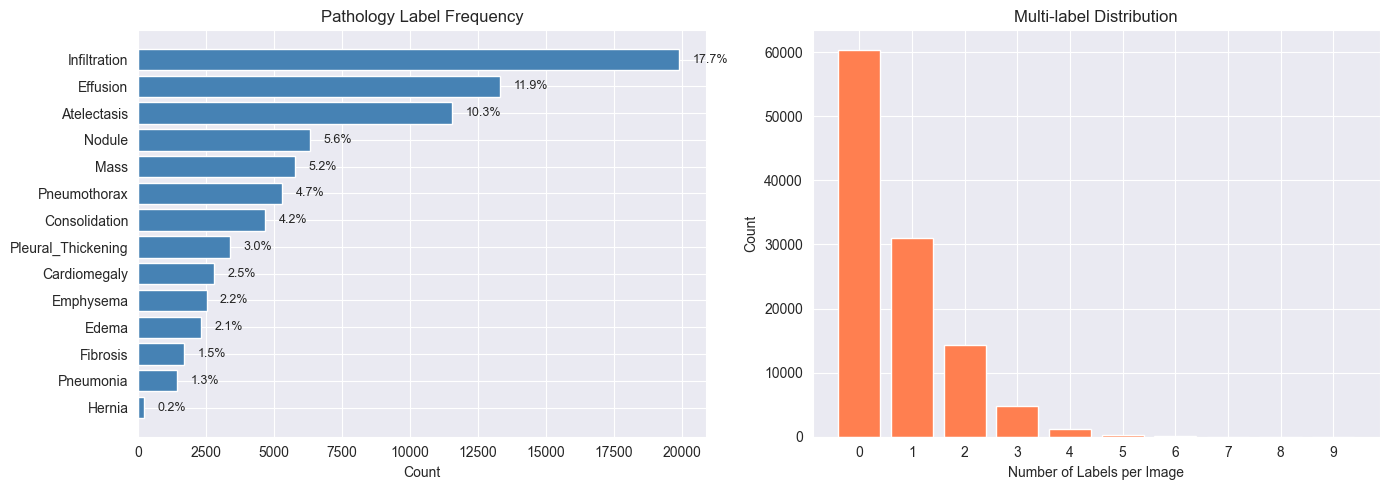


No Finding (0 labels): 60,361 images (53.8%)
At least 1 label: 51,759 images


In [9]:
# Visualize label distribution

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Label frequencies
ax1 = axes[0]
labels_sorted = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
names = [x[0] for x in labels_sorted]
counts = [x[1] for x in labels_sorted]

bars = ax1.barh(names, counts, color='steelblue')
ax1.set_xlabel('Count')
ax1.set_title('Pathology Label Frequency')
ax1.invert_yaxis()

# Add percentages
for bar, count in zip(bars, counts):
    pct = count / len(df) * 100
    ax1.text(bar.get_width() + 500, bar.get_y() + bar.get_height()/2,
             f'{pct:.1f}%', va='center', fontsize=9)

# Right: Labels per image
ax2 = axes[1]
num_labels = sorted(multi_label_counts.keys())
freq = [multi_label_counts[n] for n in num_labels]

ax2.bar(num_labels, freq, color='coral')
ax2.set_xlabel('Number of Labels per Image')
ax2.set_ylabel('Count')
ax2.set_title('Multi-label Distribution')
ax2.set_xticks(num_labels)

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'results' / 'figures' / 'label_distribution.png', dpi=150)
plt.show()

print(f"\nNo Finding (0 labels): {multi_label_counts[0]:,} images ({multi_label_counts[0]/len(df)*100:.1f}%)")
print(f"At least 1 label: {len(df) - multi_label_counts[0]:,} images")

In [10]:
# Compute co-occurrence matrix (preview of asymmetric dependencies)

print("Computing label co-occurrence matrix...")

# Parse all labels
all_labels = np.zeros((len(df), len(LABELS)), dtype=np.float32)
for i, finding in enumerate(df['Finding Labels']):
    all_labels[i] = parse_labels(finding, LABELS)

# Compute asymmetric co-occurrence: P(j|k) = P(Y_j=1 | Y_k=1)
K = len(LABELS)
co_occurrence = np.zeros((K, K))

for k in range(K):
    k_present = all_labels[:, k] == 1
    n_k = k_present.sum()

    if n_k > 0:
        for j in range(K):
            if k == j:
                co_occurrence[k, j] = 1.0
            else:
                both = (k_present & (all_labels[:, j] == 1)).sum()
                co_occurrence[k, j] = both / n_k

print("Done!")

Computing label co-occurrence matrix...
Done!


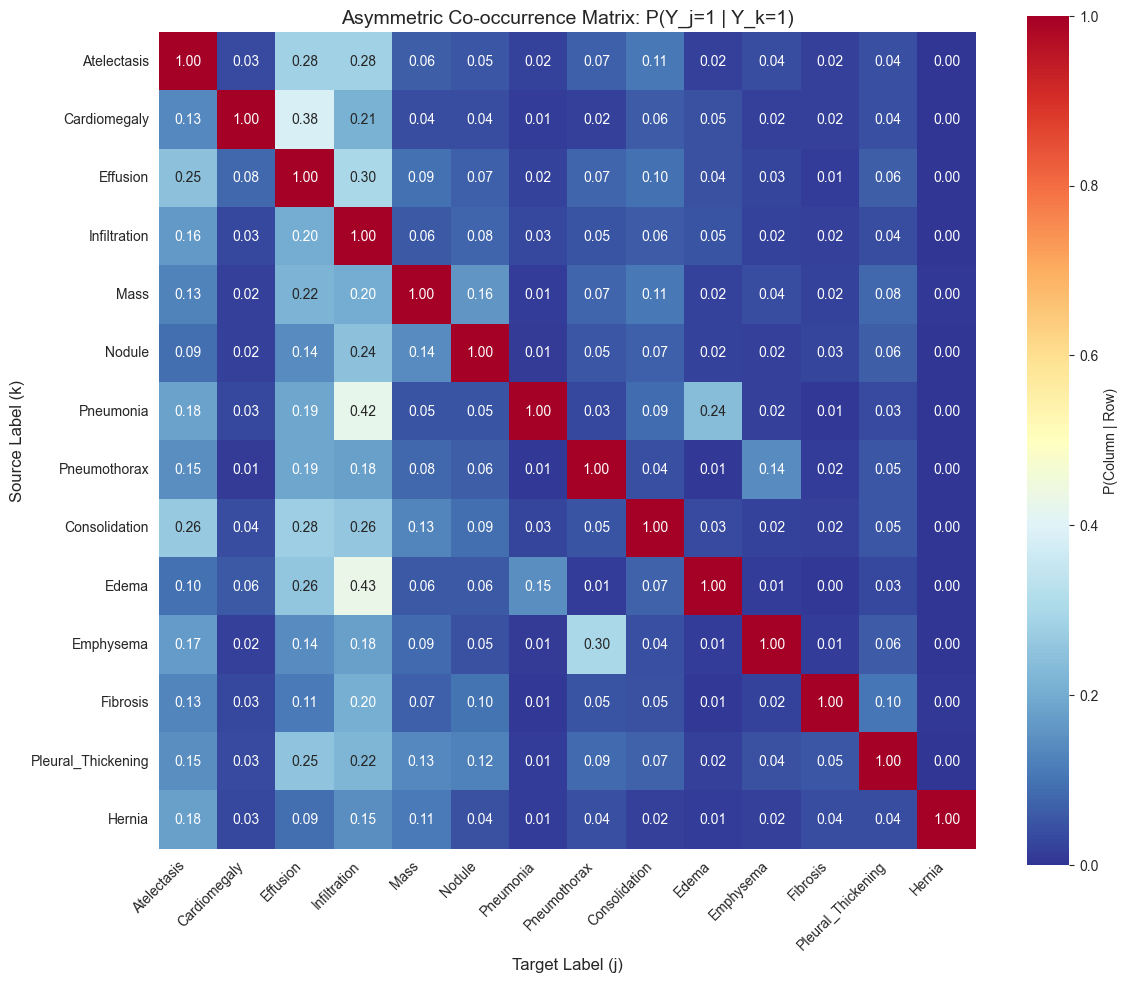

In [11]:
# Visualize co-occurrence matrix

fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(
    co_occurrence,
    annot=True,
    fmt='.2f',
    cmap='RdYlBu_r',
    vmin=0,
    vmax=1,
    xticklabels=LABELS,
    yticklabels=LABELS,
    ax=ax,
    square=True,
    cbar_kws={'label': 'P(Column | Row)'}
)

ax.set_xlabel('Target Label (j)', fontsize=12)
ax.set_ylabel('Source Label (k)', fontsize=12)
ax.set_title('Asymmetric Co-occurrence Matrix: P(Y_j=1 | Y_k=1)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'results' / 'figures' / 'co_occurrence_matrix.png', dpi=150)
plt.show()

In [12]:
# Find most asymmetric pairs

print("Most Asymmetric Label Pairs:")
print("-" * 70)

asymmetries = []
for k in range(K):
    for j in range(k+1, K):
        forward = co_occurrence[k, j]  # P(j|k)
        reverse = co_occurrence[j, k]  # P(k|j)
        asym = abs(forward - reverse)

        if forward > 0.05 or reverse > 0.05:  # Filter out near-zero pairs
            asymmetries.append((LABELS[k], LABELS[j], forward, reverse, asym))

asymmetries.sort(key=lambda x: x[4], reverse=True)

print(f"{'Source':<20} {'Target':<20} {'P(T|S)':<10} {'P(S|T)':<10} {'Δ':<10}")
print("-" * 70)
for src, tgt, fwd, rev, asym in asymmetries[:10]:
    print(f"{src:<20} {tgt:<20} {fwd:<10.3f} {rev:<10.3f} {asym:<10.3f}")

Most Asymmetric Label Pairs:
----------------------------------------------------------------------
Source               Target               P(T|S)     P(S|T)     Δ         
----------------------------------------------------------------------
Infiltration         Pneumonia            0.030      0.423      0.392     
Infiltration         Edema                0.049      0.426      0.377     
Cardiomegaly         Effusion             0.383      0.080      0.303     
Effusion             Edema                0.045      0.257      0.213     
Infiltration         Consolidation        0.061      0.262      0.200     
Infiltration         Fibrosis             0.017      0.205      0.187     
Effusion             Pleural_Thickening   0.064      0.251      0.187     
Infiltration         Pleural_Thickening   0.038      0.222      0.184     
Cardiomegaly         Infiltration         0.211      0.030      0.182     
Effusion             Consolidation        0.097      0.276      0.179     


In [13]:
# Create patient-level splits

print("\nCreating patient-level train/val/cal/test splits...")

# Get unique patients
patients = df['Patient ID'].unique()
n_patients = len(patients)
print(f"Total patients: {n_patients:,}")

# Shuffle with fixed seed for reproducibility
np.random.seed(2024)
np.random.shuffle(patients)

# Split ratios: 70/10/10/10
n_train = int(0.70 * n_patients)
n_val = int(0.10 * n_patients)
n_cal = int(0.10 * n_patients)
# n_test = remaining

train_patients = set(patients[:n_train])
val_patients = set(patients[n_train:n_train + n_val])
cal_patients = set(patients[n_train + n_val:n_train + n_val + n_cal])
test_patients = set(patients[n_train + n_val + n_cal:])

print(f"\nPatient splits:")
print(f"  Train: {len(train_patients):,} patients")
print(f"  Val:   {len(val_patients):,} patients")
print(f"  Cal:   {len(cal_patients):,} patients")
print(f"  Test:  {len(test_patients):,} patients")


Creating patient-level train/val/cal/test splits...
Total patients: 30,805

Patient splits:
  Train: 21,563 patients
  Val:   3,080 patients
  Cal:   3,080 patients
  Test:  3,082 patients


In [14]:
# Assign split to each image

def get_split(patient_id):
    if patient_id in train_patients:
        return 'train'
    elif patient_id in val_patients:
        return 'val'
    elif patient_id in cal_patients:
        return 'cal'
    else:
        return 'test'

df['split'] = df['Patient ID'].apply(get_split)

print("\nImage counts per split:")
print(df['split'].value_counts())


Image counts per split:
split
train    78440
test     11482
val      11244
cal      10954
Name: count, dtype: int64


In [15]:
# Verify label distribution is similar across splits

print("\nLabel distribution by split (% of images with each label):")
print("-" * 70)

split_stats = {}
for split in ['train', 'val', 'cal', 'test']:
    split_df = df[df['split'] == split]
    split_labels = np.zeros((len(split_df), len(LABELS)))

    for i, finding in enumerate(split_df['Finding Labels'].values):
        split_labels[i] = parse_labels(finding, LABELS)

    prevalence = split_labels.mean(axis=0) * 100
    split_stats[split] = prevalence

# Display as table
print(f"{'Label':<20} {'Train':>8} {'Val':>8} {'Cal':>8} {'Test':>8}")
print("-" * 70)
for i, label in enumerate(LABELS):
    print(f"{label:<20} {split_stats['train'][i]:>7.1f}% {split_stats['val'][i]:>7.1f}% {split_stats['cal'][i]:>7.1f}% {split_stats['test'][i]:>7.1f}%")


Label distribution by split (% of images with each label):
----------------------------------------------------------------------
Label                   Train      Val      Cal     Test
----------------------------------------------------------------------
Atelectasis             10.2%    10.4%    10.8%    10.6%
Cardiomegaly             2.5%     2.5%     2.2%     2.3%
Effusion                12.1%    10.1%    11.6%    12.1%
Infiltration            17.8%    17.9%    16.5%    18.4%
Mass                     5.1%     5.3%     4.6%     5.6%
Nodule                   5.6%     6.1%     5.7%     5.5%
Pneumonia                1.3%     1.1%     1.2%     1.6%
Pneumothorax             4.7%     4.9%     4.7%     5.0%
Consolidation            4.2%     3.6%     4.2%     4.6%
Edema                    2.1%     1.6%     1.8%     2.1%
Emphysema                2.3%     2.2%     2.2%     2.0%
Fibrosis                 1.5%     1.3%     1.7%     1.5%
Pleural_Thickening       3.1%     2.7%     2.8%     2.9%


In [16]:
# Save the processed data

print("\nSaving processed data...")

# Save the dataframe with splits
output_path = DATA_DIR / "metadata_with_splits.csv"
df.to_csv(output_path, index=False)
print(f"  Saved: {output_path}")

# Save split patient lists (for reproducibility)
splits_path = DATA_DIR / "patient_splits.npz"
np.savez(
    splits_path,
    train_patients=np.array(list(train_patients)),
    val_patients=np.array(list(val_patients)),
    cal_patients=np.array(list(cal_patients)),
    test_patients=np.array(list(test_patients))
)
print(f"  Saved: {splits_path}")

# Save label list
labels_path = DATA_DIR / "labels.txt"
with open(labels_path, 'w') as f:
    for label in LABELS:
        f.write(label + '\n')
print(f"  Saved: {labels_path}")

# Save co-occurrence matrix
co_oc_path = DATA_DIR / "co_occurrence_matrix.npy"
np.save(co_oc_path, co_occurrence)
print(f"  Saved: {co_oc_path}")

# Store Kaggle path for image loading
kaggle_path_file = DATA_DIR / "kaggle_path.txt"
with open(kaggle_path_file, 'w') as f:
    f.write(str(kaggle_path))
print(f"  Saved: {kaggle_path_file}")


Saving processed data...
  Saved: /Users/ADRIAN/Dev/College/Research Project/data/chestxray14/metadata_with_splits.csv
  Saved: /Users/ADRIAN/Dev/College/Research Project/data/chestxray14/patient_splits.npz
  Saved: /Users/ADRIAN/Dev/College/Research Project/data/chestxray14/labels.txt
  Saved: /Users/ADRIAN/Dev/College/Research Project/data/chestxray14/co_occurrence_matrix.npy
  Saved: /Users/ADRIAN/Dev/College/Research Project/data/chestxray14/kaggle_path.txt


In [17]:
# Summary

print("\n" + "="*60)
print("DATA EXPLORATION COMPLETE")
print("="*60)
print(f"""
Dataset: ChestX-ray14 (NIH)
Total images: {len(df):,}
Total patients: {n_patients:,}
Labels: {len(LABELS)} pathologies

Splits (patient-level):
  Train: {len(train_patients):,} patients ({df[df['split']=='train'].shape[0]:,} images)
  Val:   {len(val_patients):,} patients ({df[df['split']=='val'].shape[0]:,} images)
  Cal:   {len(cal_patients):,} patients ({df[df['split']=='cal'].shape[0]:,} images)
  Test:  {len(test_patients):,} patients ({df[df['split']=='test'].shape[0]:,} images)

Key asymmetric dependencies found:
  {asymmetries[0][0]} → {asymmetries[0][1]}: Δ = {asymmetries[0][4]:.2f}
  {asymmetries[1][0]} → {asymmetries[1][1]}: Δ = {asymmetries[1][4]:.2f}
  {asymmetries[2][0]} → {asymmetries[2][1]}: Δ = {asymmetries[2][4]:.2f}

Files saved:
  - {output_path.name}
  - {splits_path.name}
  - {labels_path.name}
  - {co_oc_path.name}

Next step: Run notebook 02_train_classifier.ipynb
""")


DATA EXPLORATION COMPLETE

Dataset: ChestX-ray14 (NIH)
Total images: 112,120
Total patients: 30,805
Labels: 14 pathologies

Splits (patient-level):
  Train: 21,563 patients (78,440 images)
  Val:   3,080 patients (11,244 images)
  Cal:   3,080 patients (10,954 images)
  Test:  3,082 patients (11,482 images)

Key asymmetric dependencies found:
  Infiltration → Pneumonia: Δ = 0.39
  Infiltration → Edema: Δ = 0.38
  Cardiomegaly → Effusion: Δ = 0.30

Files saved:
  - metadata_with_splits.csv
  - patient_splits.npz
  - labels.txt
  - co_occurrence_matrix.npy

Next step: Run notebook 02_train_classifier.ipynb

